In [2]:
# import common libraries 
import numpy as np 
import pandas as pd 
pd.options.display.max_columns = 100 # expanding the number of columns I can view for a df in the output
import seaborn as sns
import matplotlib.pyplot as plt

# will build a linear regression and Random Forest Model and compare results
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

### Project Description

For this final project I gathered data from [Kaggle](https://www.kaggle.com/) containing game-by-game statistics across every NHL season from 2002-2019, however for the sake of my analysis I limited the data to only games played between 2010-2019 (data prior to 2010 was unreliable). My goal is to predict a team's efficiency throughout the entirety of a season using aggregated game statistics over the course of a single year. A few of the statistics I aggregated and used as input features include goals per game, saves per game, face-off winning percentage per game, etc.

To define a team's "efficiency", I calculated each teams total points earned throughout the year as a fraction of the total possible points to be earned in a single year. There is a standard number of possible points that each team can earn in a given season if they were to win every game (164), and considering each team plays the same number of games, this number does not change from team to team. 

This is a regression problem, and in order to make the most accurate predictions I will build a linear regresssion model with Ridge regression, a linear regression model with lasso regression, and a Random Forest regression model.

**Project GitHub Page**

- The link to my project can be found on my GitHub page [here](https://github.com/elutins/MSDS_DTSA_5509)<br>
- raw link: https://github.com/elutins/MSDS_DTSA_5509


In [3]:
# Loading in necessary datasets
# Note: I created this notebook within a default Kaggle environment, and therefore the paths to the dataset and the data itself is readily available
# If you were to run this notebook outside of the default Kaggle environment, you would have to slightly alter how these data files are read in 
df_team_stats = pd.read_csv("/kaggle/input/nhl-game-data/game_teams_stats.csv")
df_goalie_stats = pd.read_csv("/kaggle/input/nhl-game-data/game_goalie_stats.csv")
df_team_info = pd.read_csv("/kaggle/input/nhl-game-data/team_info.csv")
df_game_info = pd.read_csv("/kaggle/input/nhl-game-data/game.csv")

**About the Data:**

1. `df_team_stats` --> a "one row per team game" dataframe that contains several team based statistics for each game the team played. These statistics include the number of goals the team scored, the number of shots the team took in the game, the number of hits the team recorded in the game, etc. This will be one of the main dataframes I use to aggregate team stats over a single season

2. `df_goalie_stats` --> a "one row per goalie per game" dataframe that contains several goalie based statistics for each game that the goalie played in. These statistics include the number of goals allowed in each game, the number of shots faced in each game, the number of saves in each game, etc. I will merge this dataset with `df_team_stats` to enrich my final dataframe with both team and goalie based statistics

3. `df_team_info` --> a "one row per team" dataframe. I will merely use this dataset to grab the team's actual city name (Pittsburgh, Philadelphie, etc) opposed to a numerical identifier that is used in the other datasets. `df_team_info` will not serve any modeling purpose, strcitly used to interpret and display results in a more understandable manner.

4. `df_game_info` --> a "one row per game" dataframe. This dataframe is needed to assign each game to a specific season in which the game was played. Because I will be aggregating team stats over an entire season, this dataframe is needed to be able to properly do so. 


**In the cells below I will merge the three datasets into one dataframe that I will use to aggregate team statistics over the course of a single season**

#### Data Cleaning

In [4]:
# viewing a portion of the final dataframe to make sure all the fields look good before proceeding
df_goalie_stats.sample(5)

,game_id,player_id,team_id,timeOnIce,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,decision,savePercentage,powerPlaySavePercentage,evenStrengthSavePercentage
40222,2000020343,8458584,11,3533,0,0,0,28,25,4,0,21,0,24,4,L,89.285714,100.0,87.500000
43021,2001021124,8451837,29,3067,0,0,0,23,16,0,1,15,1,21,1,NaN,69.565217,0.0,71.428571
19203,2010020298,8470140,25,3477,0,0,0,25,22,0,1,21,1,24,0,L,88.000000,NaN,87.500000
10718,2012020122,8460705,2,3496,0,0,0,26,24,3,3,18,3,19,4,L,92.307692,75.0,94.736842
22557,2009020453,8462052,4,3503,0,0,0,24,23,2,1,20,1,21,2,L,95.833333,100.0,95.238095


In [5]:
# noticed duplicates in my new dataframe; dropping duplicates
duplicate_rows = sum(df_goalie_stats.duplicated())
print(f"number of duplicate rows: {duplicate_rows}")

# dropping duplicates
df_goalie_stats = df_goalie_stats.drop_duplicates().reset_index(drop=True)

# check to assure the above code worked - this print statement should now be 0
assert sum(df_goalie_stats.duplicated()) == 0, "drop_duplicates did not work correctly"

number of duplicate rows: 5493


In [6]:
# There are instances where a team will play multiple goalies in a single game. In these instances I want to aggregate both goalie's statistics to 
# derive a overall goalie performance for that team in a single game.
cols_to_aggregate = [
    "shots", "saves", "powerPlaySaves", "shortHandedSaves", "evenSaves", "shortHandedShotsAgainst", "evenShotsAgainst", "powerPlayShotsAgainst"
]
df_goalie_stats = df_goalie_stats.groupby("game_id")[cols_to_aggregate].agg('sum').reset_index()

df_goalie_stats.sample(3)

,game_id,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst
6779,2006020630,51,45,8,2,35,2,38,11
2359,2001021130,61,52,8,1,43,1,52,8
8540,2007021161,52,47,12,4,31,4,33,15


In [7]:
# MERGING IN GOALIE STATS WITH TEAM STATS

# before doing so, there is a "shots" field in both dataframes. In order to avoid confusion about which 'shots' field applies to which dataframe,
# I am going to rename the 'shots' field in df_goalie_stats to be more appropriate/descriptive
df_goalie_stats = df_goalie_stats.rename(columns={"shots": "shotsAgainst"})

# dropping duplicates before anything else
df_team_stats = df_team_stats.drop_duplicates().reset_index(drop=True)

# merging in goalie dataframe base on game_id
df_team_stats = df_team_stats.merge(df_goalie_stats, on="game_id", how="left")

# viewing sample of dataframe
df_team_stats.sample(3)

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,shotsAgainst,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst
13709,2013020437,27,away,False,OT,Dave Tippett,2.0,39.0,26.0,4.0,2.0,0.0,60.3,10.0,6.0,10.0,left,71.0,66.0,4.0,1.0,61.0,1.0,65.0,5.0
29469,2002021131,27,away,False,REG,Bob Francis,0.0,15.0,26.0,30.0,4.0,0.0,NaN,8.0,4.0,5.0,left,49.0,48.0,10.0,3.0,35.0,3.0,36.0,10.0
4338,2015020776,3,away,True,OT,Alain Vigneault,2.0,28.0,28.0,19.0,2.0,0.0,47.8,8.0,5.0,18.0,left,56.0,52.0,8.0,1.0,43.0,1.0,46.0,9.0


In [8]:
# merging the newly made df_team_stats with df_game_info in order to assign the appropriate season each game within df_team_stats was played
df_team_stats = df_team_stats.merge(df_game_info[["game_id", "season", "type"]], on="game_id", how="left") 

# this merged dataframe includes games from both the regular season and the playoffs. For my analysis I am only concerned with games 
# played during the regular season, so I will filter the dataframe accordingly
df_team_stats = df_team_stats[df_team_stats.type == "R"].reset_index(drop=True)

# the field season is a 8 digit string representation, the first 4 digits representing the calendar year which the season started, and the second four
# digits representing the calendar year which the season ended. For the sake of this analysis I am going to constrict the season to the calendar year
# in which the season STARTED. this will be important when I aggregate the stats by year 
df_team_stats['season'] = df_team_stats['season'].astype(str).str[:4]

In [9]:
# again dropping duplicated rows
df_team_stats = df_team_stats.drop_duplicates().reset_index(drop=True)

df_team_stats.sample(3)

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,shotsAgainst,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,season,type
11560,2012020644,2,away,True,REG,Jack Capuano,5.0,38.0,25.0,18.0,5.0,1.0,57.1,13.0,13.0,22.0,left,59.0,51.0,4.0,0.0,47.0,0.0,52.0,7.0,2012,R
34706,2005020019,4,home,True,REG,Ken Hitchcock,5.0,33.0,15.0,20.0,5.0,0.0,NaN,11.0,9.0,15.0,left,61.0,54.0,21.0,3.0,30.0,4.0,34.0,23.0,2005,R
3795,2015021192,8,home,False,REG,Michel Therrien,1.0,33.0,18.0,10.0,6.0,1.0,45.8,13.0,8.0,8.0,left,52.0,47.0,8.0,2.0,37.0,2.0,39.0,11.0,2015,R


#### Handling Null Columns

- As I show in the below cells, all nulls in the dataframe stem from seasons prior to 2010. The entire dataset contains games from years 2002-2019, so if I drop all seasons prior to 2010, I will still be left with 9 years worth of data. This is plenty of data for my purpose, so rather than keeping older nulls and trying to approximate null values, I will instead restrict the dataset to only include seasons including and after 2010.

In [1]:
df_team_stats["season"] = df_team_stats["season"].astype(int)
print("unique seasons in dataset:", df_team_stats["season"].unique())
print("--------------------")

print("null value counts for data prior to 2010 season:\n")
print(df_team_stats[df_team_stats.season < 2010].isnull().sum())

print("--------------------")
print("null value counts for data including and after 2010 season:\n")
# Note: even though the field 'startRinkSide' still has null values after 2010, I will not be using this column in my final model building/analysis 
# so I can ignore those null counts
df_team_stats[df_team_stats.season >= 2010].isnull().sum()

NameError: name 'df_team_stats' is not defined

In [11]:
# restricting dataframe to only include games played after 2010
df_team_stats = df_team_stats[df_team_stats.season >= 2010].reset_index(drop=True)
df_team_stats.sample(3)

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,shotsAgainst,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,season,type
14092,2011021105,20,away,False,OT,Brent Sutter,2.0,29.0,9.0,12.0,6.0,2.0,48.4,6.0,3.0,21.0,left,59.0,55.0,13.0,1.0,41.0,1.0,42.0,16.0,2011,R
17092,2011020270,17,away,False,REG,Mike Babcock,2.0,42.0,15.0,2.0,3.0,2.0,39.6,9.0,4.0,7.0,right,70.0,63.0,7.0,2.0,54.0,3.0,58.0,9.0,2011,R
18379,2011020105,13,home,True,REG,Kevin Dineen,4.0,33.0,17.0,15.0,2.0,0.0,44.6,0.0,9.0,7.0,left,60.0,55.0,14.0,2.0,39.0,2.0,42.0,16.0,2011,R


#### Building final dataframe to use for modeling

- Right now I have a dataset containing rows for each game that each team played in a single season. However my objective is to use a team's aggregated single season stats to predict their points percentage for a given year. Because of this objective, I need to properly calculate a team's stats for the entirety of a season

In [12]:
print(df_team_stats.columns)
df_team_stats[:3]

Index(['game_id', 'team_id', 'HoA', 'won', 'settled_in', 'head_coach', 'goals',
       'shots', 'hits', 'pim', 'powerPlayOpportunities', 'powerPlayGoals',
       'faceOffWinPercentage', 'giveaways', 'takeaways', 'blocked',
       'startRinkSide', 'shotsAgainst', 'saves', 'powerPlaySaves',
       'shortHandedSaves', 'evenSaves', 'shortHandedShotsAgainst',
       'evenShotsAgainst', 'powerPlayShotsAgainst', 'season', 'type'],
      dtype='object')


,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,shotsAgainst,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,season,type
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,left,54.0,44.0,4.0,0.0,40.0,0.0,46.0,8.0,2016,R
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,left,54.0,44.0,4.0,0.0,40.0,0.0,46.0,8.0,2016,R
2,2017020812,24,away,True,OT,Randy Carlyle,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,14.0,right,66.0,59.0,5.0,3.0,51.0,4.0,55.0,7.0,2017,R


In [13]:
cols_to_sum = [
    'goals', 'shots', 'hits', 'pim', 'powerPlayOpportunities',
    'powerPlayGoals','giveaways', 'takeaways', 
    'blocked', 'shotsAgainst', 'saves', 'powerPlaySaves',
    'shortHandedSaves', 'evenSaves', 'shortHandedShotsAgainst',
    'evenShotsAgainst', 'powerPlayShotsAgainst'
]
cols_to_average = ["faceOffWinPercentage"]

# building aggregation dict to feed into below snippet
agg_dict = {col:"sum" for col in cols_to_sum}
agg_dict.update({col:"mean" for col in cols_to_average})

# notice I am renaming the dataframe now to be more descriptive
df_team_season_stats = df_team_stats.groupby(["season", "team_id"]).agg(agg_dict).reset_index()

df_team_season_stats.sample(3)

,season,team_id,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,giveaways,takeaways,blocked,shotsAgainst,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,faceOffWinPercentage
136,2014,18,226.0,2614.0,1691.0,693.0,259.0,42.0,660.0,529.0,1180.0,4913.0,4504.0,611.0,93.0,3800.0,101.0,4115.0,697.0,48.948780
240,2017,54,268.0,2687.0,1767.0,560.0,248.0,53.0,779.0,855.0,1179.0,5186.0,4716.0,660.0,116.0,3941.0,129.0,4303.0,754.0,48.898780
97,2013,8,209.0,2331.0,1722.0,1063.0,279.0,48.0,646.0,446.0,1491.0,4856.0,4462.0,703.0,142.0,3617.0,155.0,3910.0,791.0,49.791463


In [14]:
# Re-Calculating fields to be on a "per game" basis for better interpretability of final model
# because each team plays 82 games throughout a season, these numbers will all be scaled by the same factor (82), so this should not effect the
# training and predictions of the final model
cols_to_scale = [
    'goals', 'shots', 'hits', 'pim', 'powerPlayOpportunities',
    'powerPlayGoals','giveaways', 'takeaways', 
    'blocked', 'shotsAgainst', 'saves', 'powerPlaySaves',
    'shortHandedSaves', 'evenSaves', 'shortHandedShotsAgainst',
    'evenShotsAgainst', 'powerPlayShotsAgainst', "faceOffWinPercentage"
]
for col in cols_to_scale:
    df_team_season_stats[f"{col}_per_game"] = df_team_season_stats[col] / 82
    
    
df_team_season_stats.sample(3)

,season,team_id,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,giveaways,takeaways,blocked,shotsAgainst,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,faceOffWinPercentage,goals_per_game,shots_per_game,hits_per_game,pim_per_game,powerPlayOpportunities_per_game,powerPlayGoals_per_game,giveaways_per_game,takeaways_per_game,blocked_per_game,shotsAgainst_per_game,saves_per_game,powerPlaySaves_per_game,shortHandedSaves_per_game,evenSaves_per_game,shortHandedShotsAgainst_per_game,evenShotsAgainst_per_game,powerPlayShotsAgainst_per_game,faceOffWinPercentage_per_game
35,2011,6,260.0,2653.0,1778.0,1103.0,250.0,43.0,538.0,456.0,1054.0,5080.0,4635.0,609.0,132.0,3894.0,141.0,4244.0,695.0,54.604878,3.170732,32.353659,21.682927,13.451220,3.048780,0.524390,6.560976,5.560976,12.853659,61.951220,56.524390,7.426829,1.609756,47.487805,1.719512,51.756098,8.475610,0.665913
104,2013,16,261.0,2717.0,1375.0,699.0,257.0,50.0,641.0,583.0,1023.0,4932.0,4472.0,632.0,95.0,3745.0,108.0,4097.0,727.0,51.815854,3.182927,33.134146,16.768293,8.524390,3.134146,0.609756,7.817073,7.109756,12.475610,60.146341,54.536585,7.707317,1.158537,45.670732,1.317073,49.963415,8.865854,0.631901
250,2018,10,286.0,2736.0,1421.0,503.0,211.0,46.0,1002.0,695.0,1113.0,5425.0,4920.0,567.0,126.0,4227.0,139.0,4633.0,653.0,53.013415,3.487805,33.365854,17.329268,6.134146,2.573171,0.560976,12.219512,8.475610,13.573171,66.158537,60.000000,6.914634,1.536585,51.548780,1.695122,56.500000,7.963415,0.646505


#### Building Dataframe with Response Variable

- Hockey uses a team's total "points" as a way to compare teams against each other in the final standing at the end of a season. Teams are awarded points in the following manner:

    - 2 points for a win; either in regulation or overtime
    - 1 point for an overtime loss
    - 0 points for a regulation time loss
    
Given the above point breakdown, because a team plays 82 games throughout a season, and there are a possible of 2 points to be earned each game, the highest number of points a team can earn throughout a season is 164 (82 x 2). I will be using the total points a team earned in a season divided by 164 as my final response variable in the model. This response variable represents a teams "points percentage" and can be intrepreted as how poorly/well the team performed throughout the year

In [15]:
df_team_stats[:2]

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,shotsAgainst,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,season,type
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,left,54.0,44.0,4.0,0.0,40.0,0.0,46.0,8.0,2016,R
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,left,54.0,44.0,4.0,0.0,40.0,0.0,46.0,8.0,2016,R


In [16]:
### print(df_team_stats.shape)

# assigning a team's points earned in a single game based on the criteria described above
# np.where(condition, value1, value2)
conditions = [
    df_team_stats.won == True,
    (df_team_stats.won == False) & (df_team_stats.settled_in != 'REG'),
    (df_team_stats.won == False) & (df_team_stats.settled_in == 'REG'),
    
]
choices = [
    2,
    1, 
    0
]
df_team_stats["points_earned"] = np.select(conditions, choices)

In [17]:
# viewing various rows of df_team_stats to verify the above code ran correctly
cols_to_view = ["game_id", "team_id", "won", "settled_in", "points_earned"]
df_team_stats[cols_to_view].sample(10)

,game_id,team_id,won,settled_in,points_earned
4000,2017020100,22,True,OT,2
13845,2011020255,20,False,REG,0
10010,2013020972,52,False,OT,1
13110,2012020593,23,True,REG,2
3002,2017020857,6,True,REG,2
17027,2010020993,2,True,OT,2
13302,2013020601,19,True,REG,2
8772,2014020437,13,False,OT,1
12474,2013020266,29,False,OT,1
10154,2013020760,19,True,REG,2


In [18]:
df_team_points = df_team_stats.groupby(["team_id", "season"]).points_earned.sum().reset_index()
df_team_points["points_percentage"] = np.round(df_team_points["points_earned"] / 164, 3)

df_team_points.sample(3)

,team_id,season,points_earned,points_percentage
211,23,2010,117,0.713
226,24,2015,103,0.628
110,12,2019,81,0.494


##### Merging Final Feature dataframe and Response Dataframe

- The result of this merge will be the final dataframe used to run EDA and model

In [19]:
df = df_team_season_stats.merge(df_team_points[["team_id", "season", "points_percentage"]], on=["team_id", "season"], how="left")
df.sample(4)

,season,team_id,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,giveaways,takeaways,blocked,shotsAgainst,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,faceOffWinPercentage,goals_per_game,shots_per_game,hits_per_game,pim_per_game,powerPlayOpportunities_per_game,powerPlayGoals_per_game,giveaways_per_game,takeaways_per_game,blocked_per_game,shotsAgainst_per_game,saves_per_game,powerPlaySaves_per_game,shortHandedSaves_per_game,evenSaves_per_game,shortHandedShotsAgainst_per_game,evenShotsAgainst_per_game,powerPlayShotsAgainst_per_game,faceOffWinPercentage_per_game,points_percentage
104,2013,16,261.0,2717.0,1375.0,699.0,257.0,50.0,641.0,583.0,1023.0,4932.0,4472.0,632.0,95.0,3745.0,108.0,4097.0,727.0,51.815854,3.182927,33.134146,16.768293,8.524390,3.134146,0.609756,7.817073,7.109756,12.475610,60.146341,54.536585,7.707317,1.158537,45.670732,1.317073,49.963415,8.865854,0.631901,0.652
81,2012,23,122.0,1351.0,1020.0,609.0,165.0,26.0,342.0,324.0,566.0,2731.0,2503.0,359.0,66.0,2078.0,68.0,2252.0,411.0,47.583333,1.487805,16.475610,12.439024,7.426829,2.012195,0.317073,4.170732,3.951220,6.902439,33.304878,30.524390,4.378049,0.804878,25.341463,0.829268,27.463415,5.012195,0.580285,0.360
275,2019,4,238.0,2246.0,1575.0,562.0,237.0,47.0,710.0,472.0,891.0,4282.0,3867.0,491.0,146.0,3230.0,156.0,3550.0,576.0,54.916667,2.902439,27.390244,19.207317,6.853659,2.890244,0.573171,8.658537,5.756098,10.865854,52.219512,47.158537,5.987805,1.780488,39.390244,1.902439,43.292683,7.024390,0.669715,0.579
263,2018,24,196.0,2271.0,1900.0,736.0,212.0,36.0,930.0,564.0,1196.0,4974.0,4552.0,664.0,111.0,3777.0,125.0,4094.0,755.0,51.397561,2.390244,27.695122,23.170732,8.975610,2.585366,0.439024,11.341463,6.878049,14.585366,60.658537,55.512195,8.097561,1.353659,46.060976,1.524390,49.926829,9.207317,0.626800,0.488


In [20]:
# assuring there are no null values in my final dataframe
assert sum(df.isnull().sum() == 0), "null records in final dataframe"

### EDA 

- In the below cells I will perform EDA prior to building the model. In this section of the notebook I will look at feature pair plots in order to compare the relationship between features, box plots to observe the spread of values for each featur, and histograms to look at the distribution of each feature

In [21]:
print(df.columns)
df.sample(3)

Index(['season', 'team_id', 'goals', 'shots', 'hits', 'pim',
       'powerPlayOpportunities', 'powerPlayGoals', 'giveaways', 'takeaways',
       'blocked', 'shotsAgainst', 'saves', 'powerPlaySaves',
       'shortHandedSaves', 'evenSaves', 'shortHandedShotsAgainst',
       'evenShotsAgainst', 'powerPlayShotsAgainst', 'faceOffWinPercentage',
       'goals_per_game', 'shots_per_game', 'hits_per_game', 'pim_per_game',
       'powerPlayOpportunities_per_game', 'powerPlayGoals_per_game',
       'giveaways_per_game', 'takeaways_per_game', 'blocked_per_game',
       'shotsAgainst_per_game', 'saves_per_game', 'powerPlaySaves_per_game',
       'shortHandedSaves_per_game', 'evenSaves_per_game',
       'shortHandedShotsAgainst_per_game', 'evenShotsAgainst_per_game',
       'powerPlayShotsAgainst_per_game', 'faceOffWinPercentage_per_game',
       'points_percentage'],
      dtype='object')


,season,team_id,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,giveaways,takeaways,blocked,shotsAgainst,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,faceOffWinPercentage,goals_per_game,shots_per_game,hits_per_game,pim_per_game,powerPlayOpportunities_per_game,powerPlayGoals_per_game,giveaways_per_game,takeaways_per_game,blocked_per_game,shotsAgainst_per_game,saves_per_game,powerPlaySaves_per_game,shortHandedSaves_per_game,evenSaves_per_game,shortHandedShotsAgainst_per_game,evenShotsAgainst_per_game,powerPlayShotsAgainst_per_game,faceOffWinPercentage_per_game,points_percentage
66,2012,7,118.0,1339.0,1079.0,630.0,163.0,23.0,385.0,300.0,718.0,2938.0,2688.0,423.0,71.0,2194.0,85.0,2371.0,482.0,46.027083,1.439024,16.329268,13.158537,7.682927,1.987805,0.280488,4.695122,3.658537,8.756098,35.829268,32.780488,5.158537,0.865854,26.756098,1.036585,28.914634,5.878049,0.561306,0.293
234,2017,26,237.0,2545.0,2115.0,735.0,240.0,49.0,838.0,396.0,1198.0,5058.0,4642.0,686.0,162.0,3794.0,171.0,4115.0,772.0,49.817073,2.890244,31.036585,25.792683,8.963415,2.926829,0.597561,10.219512,4.829268,14.609756,61.682927,56.609756,8.365854,1.975610,46.268293,2.085366,50.182927,9.414634,0.607525,0.598
46,2011,18,232.0,2261.0,1514.0,689.0,250.0,54.0,658.0,642.0,1213.0,4764.0,4348.0,566.0,82.0,3700.0,90.0,4017.0,657.0,49.078049,2.829268,27.573171,18.463415,8.402439,3.048780,0.658537,8.024390,7.829268,14.792683,58.097561,53.024390,6.902439,1.000000,45.121951,1.097561,48.987805,8.012195,0.598513,0.634


In [22]:
# instantiating final feature columns and response variable
feature_cols = [
    'goals_per_game', 'shots_per_game', 'hits_per_game', 'pim_per_game',
    'powerPlayOpportunities_per_game', 'powerPlayGoals_per_game',
    'giveaways_per_game', 'takeaways_per_game', 'blocked_per_game',
    'shotsAgainst_per_game', 'saves_per_game', 'powerPlaySaves_per_game',
    'shortHandedSaves_per_game', 'evenSaves_per_game',
    'shortHandedShotsAgainst_per_game', 'evenShotsAgainst_per_game',
    'powerPlayShotsAgainst_per_game', 'faceOffWinPercentage_per_game'
]
response = ["points_percentage"]

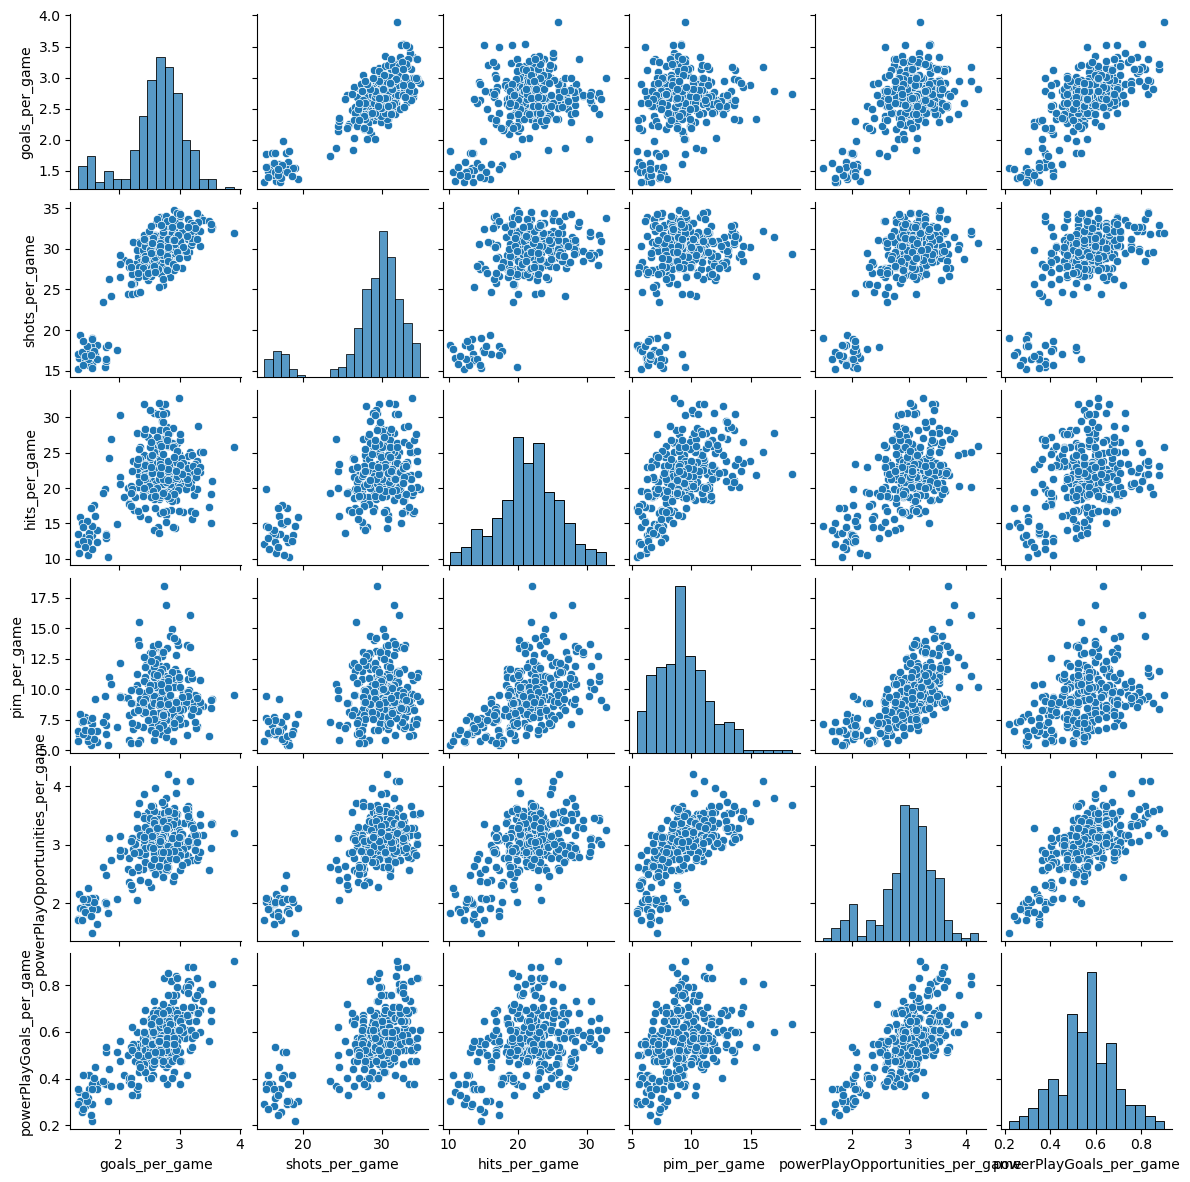

In [23]:
# looking at a subset of features in a pairplot at one time so i dont create an image that is too big to view in one screen
pairplot_cols = ['goals_per_game', 'shots_per_game', 'hits_per_game', 'pim_per_game','powerPlayOpportunities_per_game', 'powerPlayGoals_per_game']
sns.pairplot(df[pairplot_cols], diag_kind="hist", height=2, aspect=1)
plt.show()

The above pairplot shows that there are a lot of highly linearly related variables in the dataset; including `goals_per_game` and `shots_per_game`, `powerPlayOpportunities_per_game` and `powerPlayGoals_per_game`

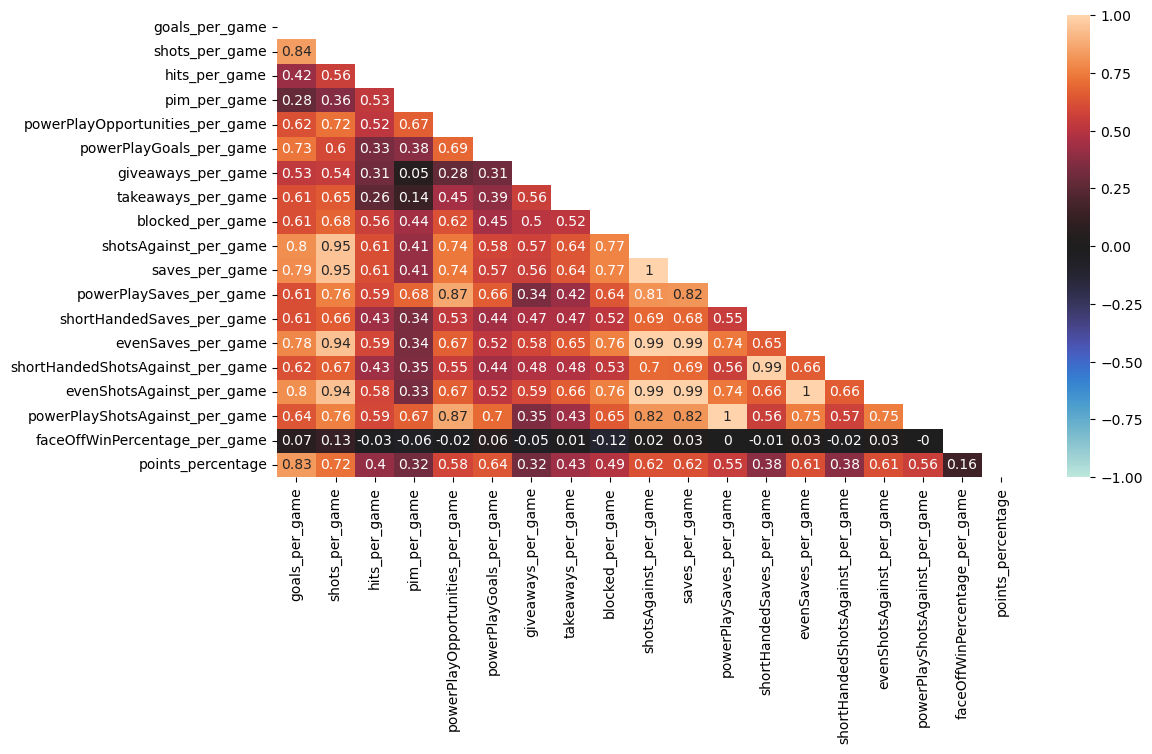

In [27]:
# looking at a correlation matrix of all features
features_and_response = feature_cols + response
corr = round(df[features_and_response].corr(),2)
mask = np.triu(np.ones_like(corr))

fig, ax = plt.subplots(figsize=(12,6)) 
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0, mask=mask)
sns.set_palette("colorblind")
plt.show()

The above correlation matrix points out that there are some feature variables that are highly correlaed with each other, and for this reason we only need to include one of the two highly correlated features. Features that are highly correlated to each other include: `goals_per_game` and `shots_per_game`, `saves_per_game` and `evenSaves_per_game`, `shots_against_per_game` and `evenSaves_per_game` amongst many others. 

#### Feature & Response Distribution

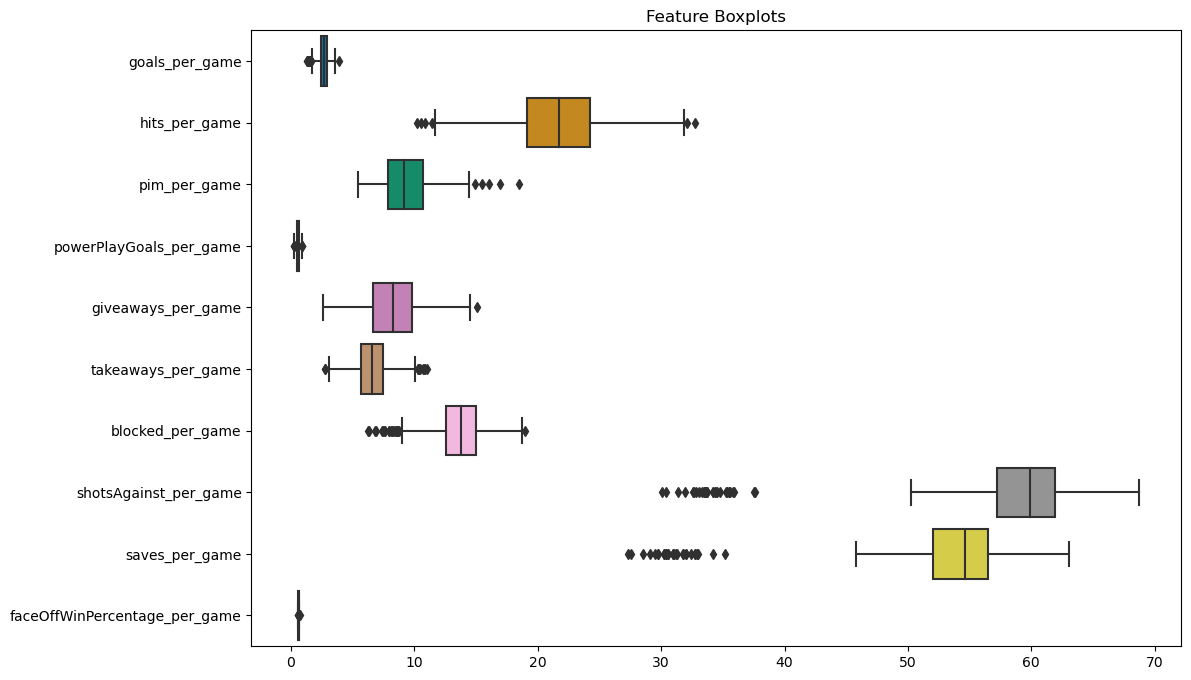

In [32]:
# creating violin plots of some of the final features that will be used in modeling
boxplot_features = [
    'goals_per_game',
    'hits_per_game',
    'pim_per_game',
    'powerPlayGoals_per_game',
    'giveaways_per_game',
    'takeaways_per_game',
    'blocked_per_game',
    'shotsAgainst_per_game',
    'saves_per_game',
    'faceOffWinPercentage_per_game',
]
fig,ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=df[boxplot_features], orient="h")

plt.title("Feature Boxplots")
plt.show()

From the above boxplot we get a sense of the range of values of some of the features that will be used for modeling. For instance, faceOffWinPercentage and goals_per_game have a much smaller range than `saves_per_game` and `shotsAgainst_per_game`.

While `saves_per_game` and `shotsAgainst_per_game` have noticeable outliers based on the above boxplot, I am going to elect to NOT exclude these points from the dataset (at least for the first round of modeling). If I see poor model performance, I will remove these outliers and try re-running the model to see if the outlier removal improved accuracy


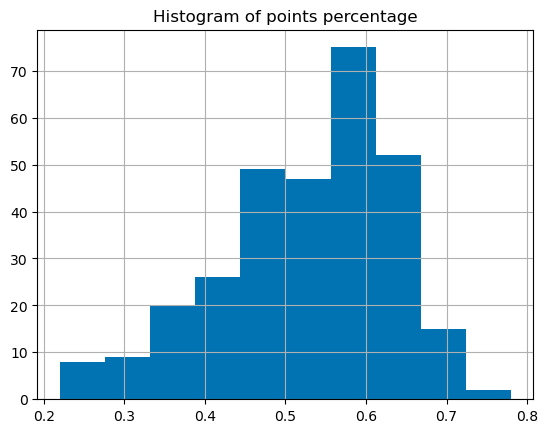

In [144]:
df.points_percentage.hist()
plt.title("Histogram of points percentage")
plt.show()

#### EDA Conclusions & Next Steps

Based on the above EDA, there are quite a few of highly correlated features. Because of this, I am going to narrow down the final feature set to only include  `goals_per_game`, `hits_per_game`, `pim_per_game`, `giveaways_per_game`,`takeaways_per_game`, `saves_per_game` and `faceOffWinPercentage_per_game`.

Additionally, because we noticed a *near* normally distribution after plotting a histogram of the response variable, I am going to test out a Linear Regression model. A *near* normally distributed response is one of the criteria for a linear regression model. I am also going to build a Random Forest model and compare the results to the Linear Regression model.

--------

### Modeling

In [41]:
model_features = [
    'goals_per_game',
    'hits_per_game',
    'pim_per_game',
    'powerPlayGoals_per_game',
    'giveaways_per_game',
    'takeaways_per_game',
    'saves_per_game',
    'faceOffWinPercentage_per_game',
]
response = ["points_percentage"]

df_model = df[model_features + response]
df_model.sample(3)

,goals_per_game,hits_per_game,pim_per_game,powerPlayGoals_per_game,giveaways_per_game,takeaways_per_game,saves_per_game,faceOffWinPercentage_per_game,points_percentage
157,2.634146,23.573171,9.439024,0.512195,10.792683,6.048780,54.426829,0.613028,0.500
48,2.426829,19.548780,10.792683,0.560976,9.926829,7.463415,53.304878,0.561556,0.549
224,2.780488,16.780488,7.475610,0.524390,8.524390,7.146341,61.073171,0.601517,0.463


#### Linear Regression

I will perform linear regression modeling in the following steps:

1. Split the data into training and test sets
2. Run a linear regression model using lasso regularization on the training data and generate mean **MSE** using k-fold cross validation 
3. Make predictions on the holdout test dataset and record the **MSE**
4. Run a linear regression model using ridge regularization on the training data and generate mean MSE using k-fold cross validation 
5. Make predictions on the holdout test dataset and record the **MSE**
6. Determine if lasso or ridge regression yields a better test **MSE**
    




In [43]:
# splitting into a training and test set
from sklearn.model_selection import train_test_split
X = df_model[model_features]
y = df_model[response]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # allocating 33% of entire data for my test set

train_obs = len(X_train)
test_obs = len(X_test) 

print(f"number of observations in training dataset: {train_obs}")
print(f"number of observations in test dataset: {test_obs}")

number of observations in training dataset: 203
number of observations in test dataset: 100


**Linear Regression using Lasso Regularization**

In [78]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

lr = Lasso()
parameters = {'alpha': [.001, .01, .1, 1]}

# by default, GridSearchCV will run using 5-fold cross validation
grid = GridSearchCV(lr, parameters, scoring="neg_mean_absolute_error")
grid.fit(X_train, y_train)

grid_results = pd.DataFrame(grid.cv_results_)

# looking at the grid search results, sorting by the best run 
grid_results.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003613,0.000225,0.002907,0.000392,0.001,{'alpha': 0.001},-0.046370,-0.047432,-0.039558,-0.050444,-0.051069,-0.046975,0.004108,1
1,0.002922,0.000177,0.002233,0.000131,0.01,{'alpha': 0.01},-0.058960,-0.058314,-0.051144,-0.059451,-0.051533,-0.055881,0.003728,2
2,0.002525,0.000022,0.002066,0.000033,0.1,{'alpha': 0.1},-0.074724,-0.079160,-0.073416,-0.076362,-0.065454,-0.073823,0.004603,3
3,0.002603,0.000038,0.002154,0.000105,1,{'alpha': 1},-0.088715,-0.097084,-0.087158,-0.082900,-0.077923,-0.086756,0.006380,4


From the above gridsearch results, we can see that the model run using `alpha=.001` yielded the best average test MSE using cross validation.

In [76]:
from sklearn.metrics import mean_squared_error

lasso_model = Lasso(alpha=.001).fit(X_train, y_train)
lasso_preds = lasso_model.predict(X_test)

lasso_test_mse = mean_squared_error(y_test, lasso_preds)
print(f"Lasso linear regression test MSE: {np.round(lasso_test_mse,4)}")

Lasso linear regression test MSE: 0.0037


**Ridge Regularization**

Performing the same steps as above but this time using Ridge Regression instead of Lasso

In [138]:
lr_ridge = Ridge()
parameters = {'alpha': [.001, .01, .1, 1]}

# by default, GridSearchCV will run using 5-fold cross validation
grid = GridSearchCV(lr_ridge, parameters, scoring="neg_mean_absolute_error")
grid.fit(X_train, y_train)

grid_results = pd.DataFrame(grid.cv_results_)

# looking at the grid search results, sorting by the best run 
grid_results.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.002851,0.000113,0.002188,0.000053,0.01,{'alpha': 0.01},-0.043680,-0.045240,-0.044474,-0.049750,-0.048916,-0.046412,0.002450,1
0,0.003455,0.000711,0.002343,0.000148,0.001,{'alpha': 0.001},-0.043487,-0.045133,-0.045029,-0.049755,-0.048735,-0.046428,0.002395,2
2,0.003268,0.000429,0.002519,0.000392,0.1,{'alpha': 0.1},-0.044727,-0.045964,-0.041804,-0.049979,-0.050005,-0.046496,0.003158,3
3,0.003191,0.000460,0.002457,0.000324,1,{'alpha': 1},-0.046231,-0.047286,-0.039660,-0.050414,-0.050862,-0.046891,0.004026,4


From the above gridsearch results, we can see that the model run using `alpha=.01` yielded the best average test MSE using cross validation.


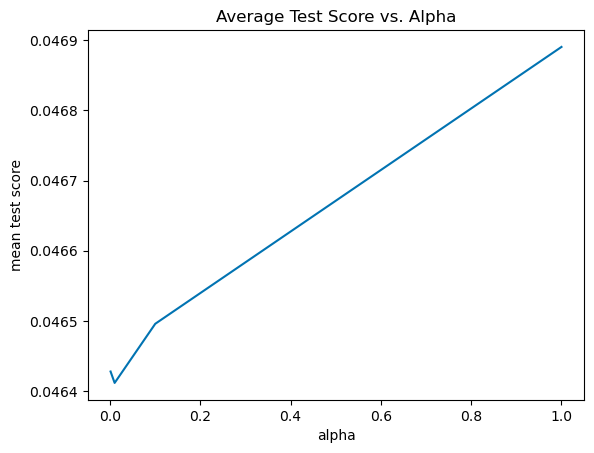

In [142]:
# plotting the average test MSE as a function of n estimators in the random forest model
grid_results["mean_test_score"] = abs(grid_results["mean_test_score"])
fig, ax = plt.subplots()
sns.lineplot(grid_results, x="param_alpha", y="mean_test_score")

plt.title("Average Test Score vs. Alpha")
plt.ylabel("mean test score")
plt.xlabel("alpha")

plt.show()

In [81]:
ridge_model = Ridge(alpha=.01).fit(X_train, y_train)
ridge_preds = ridge_model.predict(X_test)

ridge_test_mse = mean_squared_error(y_test, ridge_preds)
print(f"Lasso linear regression test MSE: {np.round(ridge_test_mse,4)}")

Lasso linear regression test MSE: 0.0036


#### Random Forest Regression

I will build and analyze a Random Forest regression model in the following steps:

1. Instantiate different parameter values for `max_depth` and `min_samples_leaf` to iterate over using GridSearch
2. Fit 5-fold cross validation GridSearch on training data (will use same training data that I used in linear regression)
3. Analyze the results of GridSearch and look at which parameters yielded the best results 
4. Using the parameters from the best GridSearch trail run, build a Random Forest model and make predictions on the test dataset. 
5. Record the test MSE and compare to the test MSE observed from regression models

In [85]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
parameters = {'max_depth': [3, 5, 8], 'min_samples_leaf': [5, 10, 15], 'n_estimators': [50, 100, 150]}

# by default, GridSearchCV will run using 5-fold cross validation
grid = GridSearchCV(rf, parameters, scoring="neg_mean_absolute_error")
grid.fit(X_train, y_train)

grid_results = pd.DataFrame(grid.cv_results_)

In [86]:
# looking at the grid search results, sorting by the best run 
grid_results.sort_values("rank_test_score")[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.114563,0.000996,0.010929,0.000620,5,5,100,"{'max_depth': 5, 'min_samples_leaf': 5, 'n_est...",-0.048784,-0.050426,-0.039232,-0.053850,-0.051414,-0.048741,0.005030,1
20,0.170525,0.001298,0.014084,0.000275,8,5,150,"{'max_depth': 8, 'min_samples_leaf': 5, 'n_est...",-0.049670,-0.050789,-0.040122,-0.052625,-0.051601,-0.048961,0.004525,2
11,0.168743,0.001590,0.014022,0.000464,5,5,150,"{'max_depth': 5, 'min_samples_leaf': 5, 'n_est...",-0.049982,-0.050783,-0.040617,-0.054149,-0.051242,-0.049355,0.004590,3
19,0.114506,0.001701,0.010086,0.000237,8,5,100,"{'max_depth': 8, 'min_samples_leaf': 5, 'n_est...",-0.050604,-0.049916,-0.040807,-0.054425,-0.051024,-0.049355,0.004548,4
9,0.059001,0.000746,0.006898,0.000161,5,5,50,"{'max_depth': 5, 'min_samples_leaf': 5, 'n_est...",-0.049943,-0.050924,-0.040746,-0.054908,-0.052019,-0.049708,0.004780,5


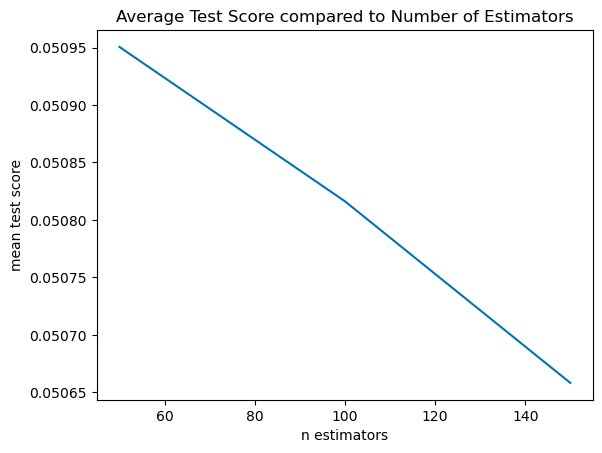

In [137]:
# plotting the average test MSE as a function of n estimators in the random forest model
df_n_estimators = pd.DataFrame(grid_results.groupby("param_n_estimators").mean_test_score.mean()).reset_index()

fig, ax = plt.subplots()
sns.lineplot(data=abs(df_n_estimators), x="param_n_estimators", y="mean_test_score")

plt.title("Average Test Score compared to Number of Estimators")
plt.ylabel("mean test score")
plt.xlabel("n estimators")

plt.show()

In [87]:
print("RF model params from best GridSearchCV trial:")
grid.best_params_

RF model params from best GridSearchCV trial:


{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}

It is interesting to note that the best parameters printed above show `n_estimators=100`. However when looking at the above plot, we can see that when ignoring all other parameter values the lowest score is recorded when `n_estimators=150`. This goes to show how the parameters of a model work together in the case of Random Forest to produce the best overall model

In [101]:
# using the parameters in the above print statement in my final model
rf = RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=100).fit(X_train, np.array(y_train).reshape(-1,))

# making predictions on test dataset
rf_preds = rf.predict(X_test)

# test MSE
rf_test_MSE = mean_squared_error(y_test, rf_preds)
print(f"Random Forest regression test MSE: {np.round(rf_test_MSE,4)}")


Random Forest regression test MSE: 0.0036


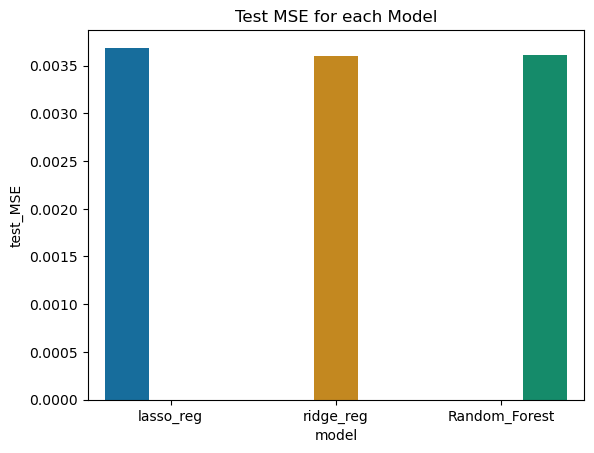

In [112]:
df_test_MSEs = pd.DataFrame({
    "model": ["lasso_reg", "ridge_reg", "Random_Forest"],
    "test_MSE": [lasso_test_mse, ridge_test_mse, rf_test_MSE]
})

fig, ax = plt.subplots()
sns.barplot(data=df_test_MSEs, x="model", y="test_MSE", hue="model")

plt.title("Test MSE for each Model")
ax.get_legend().remove()
plt.show()

In [113]:
df_test_MSEs.sort_values("test_MSE")

,model,test_MSE
1,ridge_reg,0.003605
2,Random_Forest,0.003611
0,lasso_reg,0.003689


**Based on the above plot and table, it can be seen that Ridge Regression recorded the lowest test MSE across all the models**

Below I will analyze the coefficients of the final Ridge Regression model

In [130]:
# re-instantiating the ridge regression model 
ridge_model = Ridge(alpha=.01).fit(X_train, y_train)

coefficients = ridge_model.coef_

# generating table of features and their respective coefficients
df_coef = pd.DataFrame({
    "feature": model_features,
    "coefficient": coefficients[0]
})
df_coef

,feature,coefficient
0,goals_per_game,0.227781
1,hits_per_game,0.001430
2,pim_per_game,0.003717
3,powerPlayGoals_per_game,-0.020793
4,giveaways_per_game,-0.005595
5,takeaways_per_game,-0.003781
6,saves_per_game,-0.001780
7,faceOffWinPercentage_per_game,0.442424


### Final Conclusions

After building a linear regression model using Lasso Regularization, a linear regression model using Ridge Regularization, and a Random Forest Regressor, the model with the lowest Mean Squared Error proved to be Ridge linear regression model. I believe Lasso Regularization worked the best in this scenario due to the distribution of the response variable, `points percentage`. Additionally, my hypotheses as to why Ridge regression outperformed Lasso Regression is because **Ridge** regression by design will include all of the original features in the model. Whereas the penalty term associated in Lasso Regression may cause some of the features coefficients to be 0, rendering the features useless in the final model. Because Ridge regression outperformed Lasso regression, it could be an indicator that all the features included were relevant in predicting the response variable. 

Additionally, it is important to note the scale of the Test Mean Squared Error in this model. Because the response variable was bounded to (0, 1) inclusively, the test MSE could only ever be less than 1. Therefore each minor improvement or drop in MSE across models is significant. 

Finally, in regards to next steps, I would like to advance this project even further and attempt to model player efficiency given game-by-game player statistics. There is a lot of applicability to being able to predict a player's performance and cluster players together. 

